# Complete + Tensorboard

In this notebook we show an end-to-end training example with early stopping, checkpointing and tensorboard integration. The dataset we use in this example is the famouse [California Housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).

In [1]:
import time

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
tf.__version__

'2.3.0'

In [3]:
keras.__version__

'2.4.0'

In [4]:
# load a dataset, in this case california housing.
housing = fetch_california_housing()

# Split the full dataset into train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)

# Split the train dataset into train/validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

print(f"Train dataset shape: {X_train_full.shape}, type: {X_train_full.dtype}")

Train dataset shape: (15480, 8), type: float64


In [5]:
# Scale the data. Rememeber that you train the Scaler on the train data only, and then applied the learned
# scaling to validation and train datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [6]:
def architecture():
    """Define the architecture using the functional API"""
    input_ = keras.layers.Input(shape=X_train.shape[1:], name='Input')
    hidden = keras.layers.Dense(30, activation='relu', name='Hidden_1')(input_)
    output = keras.layers.Dense(1, name='Output')(hidden)
    return keras.Model(inputs=[input_], outputs=[output])

def inspect(model):
    """Aux function to print model information"""
    print(model.summary())
    print(model.layers)
    

model = architecture()
inspect(model)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 8)]               0         
_________________________________________________________________
Hidden_1 (Dense)             (None, 30)                270       
_________________________________________________________________
Output (Dense)               (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1388d1a30>, <tensorflow.python.keras.layers.core.Dense object at 0x138a004c0>, <tensorflow.python.keras.layers.core.Dense object at 0x138a00970>]


In [7]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=[keras.metrics.mean_squared_error])

In [8]:
# Integration with Tensorboard, early stopping and checkpoints
datestr = time.strftime('%y-%m-%d-%h-%m-%s')
tensorboardcb = keras.callbacks.TensorBoard(log_dir=f'./tb_logs/tb_logs-{datestr}')

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboardcb, 
                               keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
                               keras.callbacks.ModelCheckpoint(filepath=f'./checkpoints/model-{datestr}.h5')])

Epoch 1/20
  1/363 [..............................] - ETA: 0s - loss: 6.5259 - mean_squared_error: 6.5259WARNING:tensorflow:From /Volumes/HDD_juliod/miniconda/envs/juliod_test_tf/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
363/363 [==============================] - 3s 8ms/step - loss: 0.8884 - mean_squared_error: 0.8884 - val_loss: 0.5892 - val_mean_squared_error: 0.5892
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 1.8234 - mean_squared_error: 1.8234 - val_loss: 0.5064 - val_mean_squared_error: 0.5064
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5141 - mean_squared_error: 0.5141 - val_loss: 0.4206 - val_mean_squared_error: 0.4206
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4212 - mean_squared_error: 

Now it is time to start the TensorBoard server, which we must point to the root directory that contains the different subdirectories where each training information is recoded.

```
tensorboard --logdir=./tb_logs --port=6006
```

You can also start the server using Jupyer magics:

```
%load_ext tensorboard
%tensorboard --logdir=./tb_logs --port=6006
```

Once you open tensorboard in your browser you will see something like:

![](img/tensorboard.png)

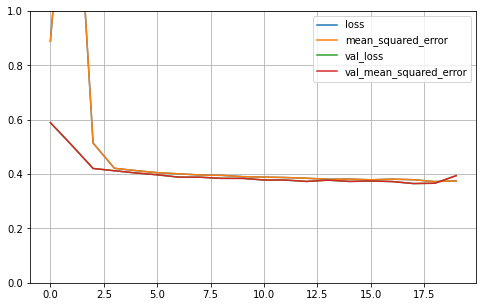

In [9]:
# plot the history
utils.print_history(history)

In [10]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 3ms/step - loss: 0.4010 - mean_squared_error: 0.4010


[0.4009561836719513, 0.4009561836719513]

In [11]:
# Use the model to produce inferences
pred = model.predict(X_test[0:1])
pred

array([[3.1949947]], dtype=float32)